# Counting Jumps

Using g-force, counting jumps are the points where the force hits- or approaches (for a quick jump) zero.

Using Dec 30, 2023 data since only 2 runs registered (easy):

In [230]:
import matplotlib.pyplot as plt
from load import load_2023_12_30
from signal_processing import lowpass, length, idxsUnderTH, mean, std
from sync import splitTileIntoDownhillTracks, syncTile
from tile import Tile

In [231]:
a50_2023_12_30, a50_all_2023_12_30, f6p_2023_12_30, tile_2023_12_30 = load_2023_12_30()

In [232]:
tile_2023_12_30_sync = syncTile(
    tile=tile_2023_12_30,
    truth=a50_all_2023_12_30,
    printOutput=True,
    # use_mae=False,
    time_step_s=0.5,
    max_time_search_s=30,
    alt_step=0.25,
    min_alt_start=120,
    max_alt_search=140)

Timestamp offset: 8000
Altitude offset: 131.75


In [233]:
tile_2023_12_30_runs = splitTileIntoDownhillTracks(tile_2023_12_30_sync, a50_2023_12_30)
print('Run count:', len(tile_2023_12_30_runs))

[[1703955989, 1703956104], [1703956733, 1703956847], [1703956907, 1703956947]]
Run count: 3


In [234]:
run1 = tile_2023_12_30_runs[0]
run2 = tile_2023_12_30_runs[1]

In [235]:
jump_mg_th = 600

run1_jumps = idxsUnderTH(run1.mG_lpf, jump_mg_th)
print('Run1')
print(len(run1_jumps), 'Jump(s):', run1_jumps)

run2_jumps = idxsUnderTH(run2.mG_lpf, jump_mg_th)
print('Run2')
print(len(run2_jumps), 'Jump(s):', run2_jumps)

Run1
94 Jump(s): [5564, 5565, 5566, 5567, 5568, 5569, 5570, 5571, 5572, 5573, 5574, 5575, 5576, 5577, 5578, 5579, 5580, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 7075, 7076, 7077, 7078, 7079, 7080, 7081, 7082, 7083, 7084, 7085, 7086, 7087, 7088, 7089, 7090, 7091, 7092, 7093, 7094, 7095, 7096, 7097, 7098, 7099, 7100, 7101, 7102, 7103, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7111, 7112, 7113, 7114, 7115, 7116, 7117, 7118, 7119, 7120, 7121, 7122, 7123, 7124, 7125, 7126, 7127, 7128, 7129, 7130]
Run2
1 Jump(s): [6649]


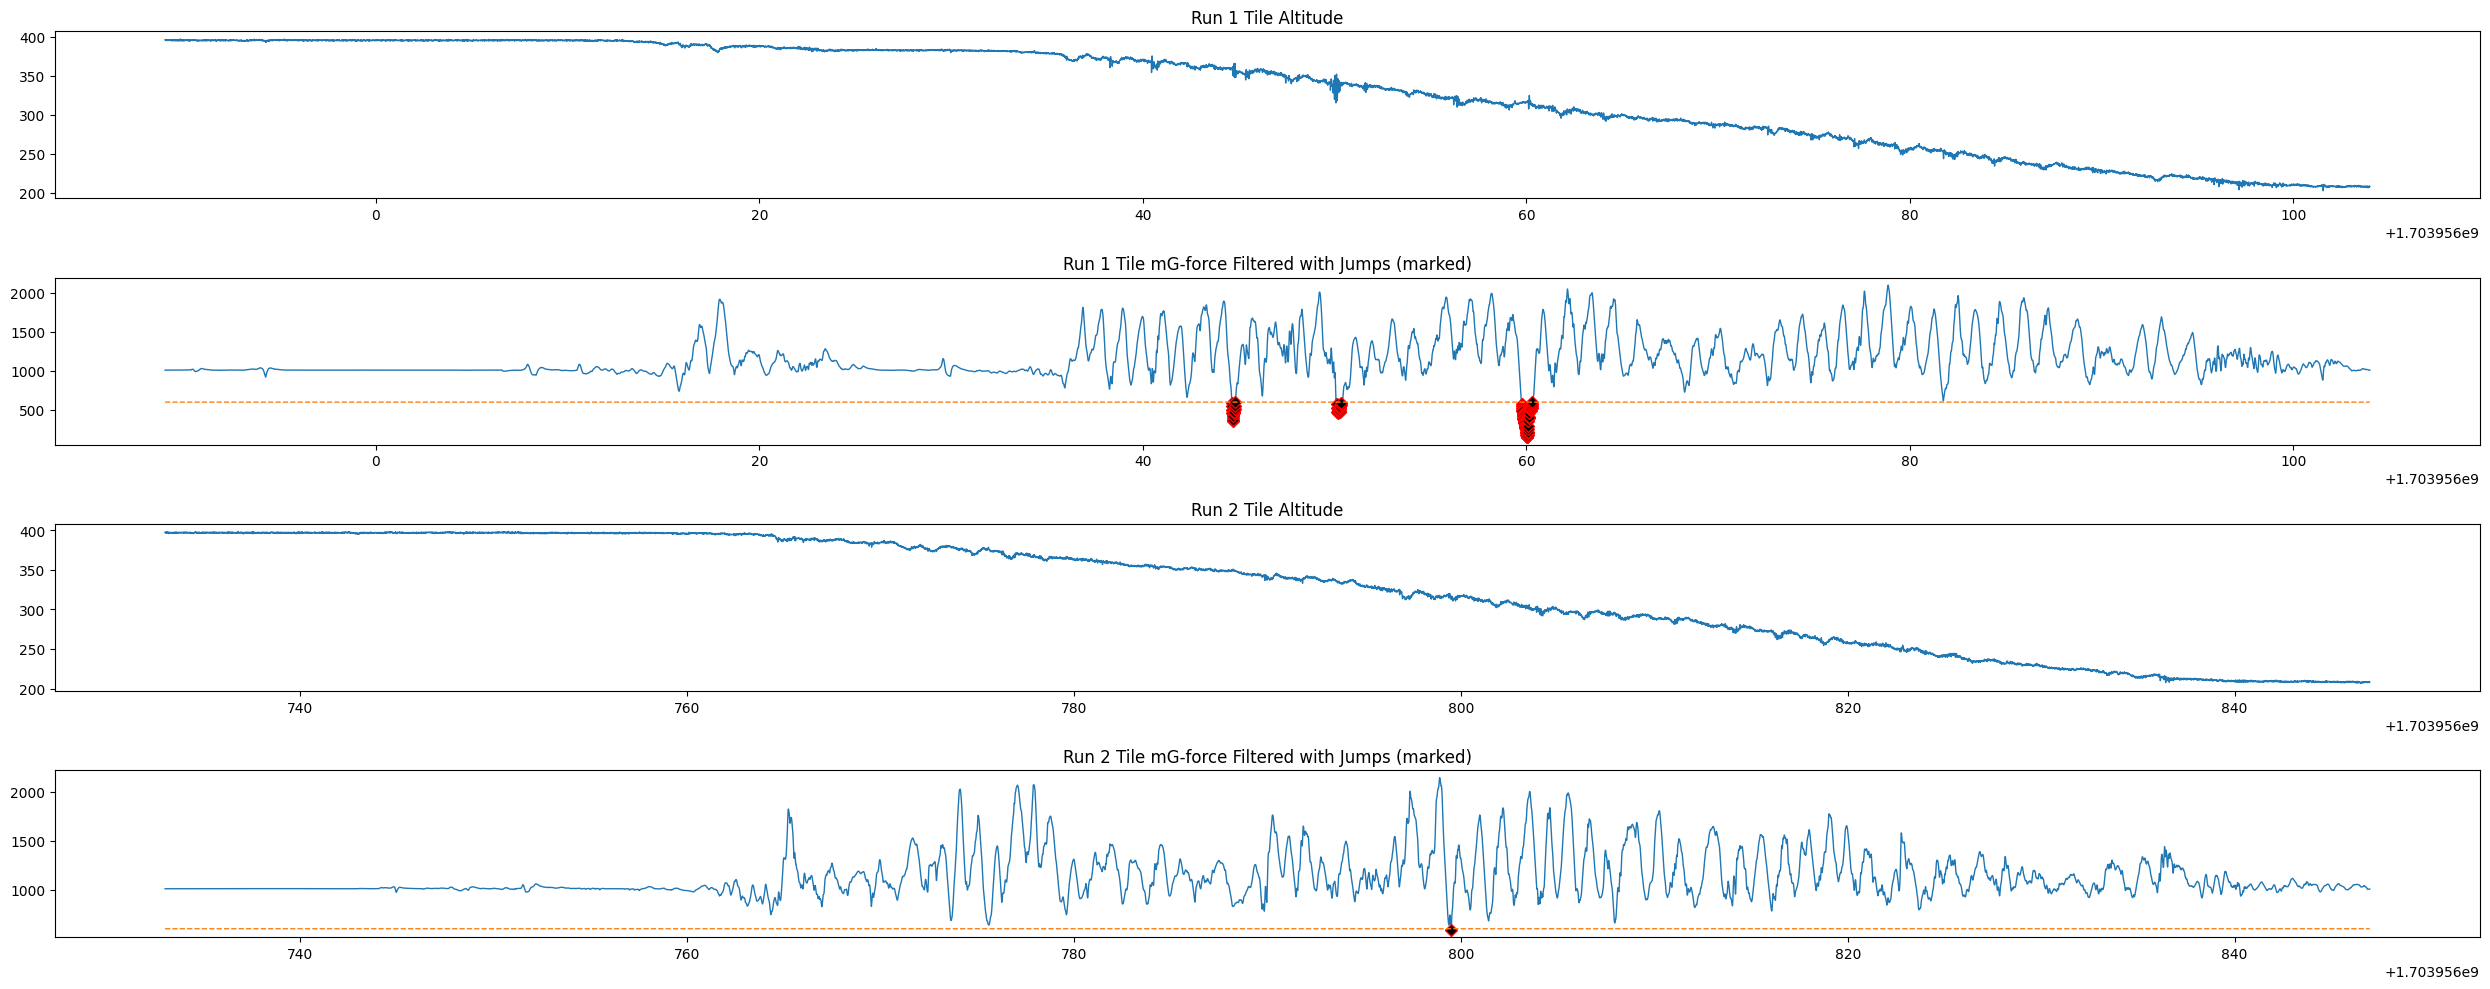

In [236]:
plt.rc('lines', linewidth=1)
_, ax = plt.subplots(4, figsize=(25, 10))
ax[0].plot(run1.time, run1.alt)
ax[0].set_title('Run 1 Tile Altitude', wrap=True)

ax[1].plot(run1.time, run1.mG_lpf, '-D', markevery=run1_jumps, mfc='k', mec='red')
ax[1].plot(run1.time, [jump_mg_th for _ in run1.mG_lpf], '--')
ax[1].set_title('Run 1 Tile mG-force Filtered with Jumps (marked)', wrap=True)

ax[2].plot(run2.time, run2.alt)
ax[2].set_title('Run 2 Tile Altitude', wrap=True)

ax[3].plot(run2.time, run2.mG_lpf, '-D', markevery=run2_jumps, mfc='k', mec='red')
ax[3].plot(run2.time, [jump_mg_th for _ in run2.mG_lpf], '--')
ax[3].set_title('Run 2 Tile mG-force Filtered with Jumps (marked)', wrap=True)

plt.tight_layout()
plt.show()

### Spot the Landing(s)!

Plot with the unfiltered acceleration magnitude, since the frequency is filtered out in the g-force signal. Use this confirm a large impulse happens after the near-zero-g to represent the landing.

### Recognition Steps

Based on these results, the steps to determine whether a jump occured using just g-force are:

- identify areas of sequential points below the 200mg threshold
  - small number of points below the threshold may not indicate jump
- use the ts of these sequential points to test whether the filtered g-force saw a strong decreasing trend before the min
- use the ts of these sequential points to test whether the signals saw low values and noise (before the min):
  - unfiltered g-force
  - unfiltered gyroscope magnitude
- use the ts again to test whether a large impulse was detected after the min:
  - unfiltered g-force
  - unfiltered gyroscope magnitude

Combining these can offer a score on whether a jump is detected. Concluing from the data, jumps:

1. jump
2. not a jump
3. jump
4. controversial, small jump. Bad timing for the min, should implement an alignment fix


> Note: You could mark these results and train a nn on jump detection instead of this analytic approach

### Range Isolations

In [237]:
def groupClosePointsIntoRanges(idxs):
    '''return list of ranges of sequential points grouped by closeness,
    
    whose changes are separated by values greater than `th`
    '''
    ranges = []
    x1 = idxs[0]
    x2 = idxs[-1]
    for i in range(len(idxs) - 1):
        if (idxs[i + 1] - idxs[i] > 2):
            ranges.append([x1, idxs[i]])
            x1 = idxs[i + 1]
    ranges.append([x1, x2])
    return ranges

In [238]:
def identifyRangesBelowTH(x, th):
    idxs = idxsUnderTH(x, th)
    return groupClosePointsIntoRanges(idxs)

In [239]:
def minIndex(x, r):
    '''returns the index wrt x'''
    if r[0] == r[1]: return r[0]
    window = x[r[0]:r[1]]
    return r[0] + window.index(min(window))

In [240]:
def maxIndex(x, r):
    '''returns the index wrt x'''
    if r[0] == r[1]: return r[0]
    window = x[r[0]:r[1]]
    return r[0] + window.index(max(window))

In [241]:
def airRange(x, min_idx, th=2):
    '''calculate the index range of total air time, where `min_idx` is the last component'''
    x1 = 0
    for i in range(len(x[0:min_idx])):
        if x[min_idx - i] - x[min_idx - (i + 1)] > th:
            x1 = min_idx - (i + 1)
            break
    return [maxIndex(x, [x1, min_idx]), min_idx]

In [242]:
def landingRange(x, min_idx, delay_s=0.5):
    '''calculate the index range of the landing phase, where `min_idx` is the first component'''
    # find the point where x is rising faster than a th (truly exiting air range)
    touch_idx = 0
    for i in range(len(x[min_idx:-1])):
        if x[min_idx + (i + 1)] - x[min_idx + i] > 10:
            touch_idx = min_idx + i + 1
            break

    # add 0.5s to it
    x2 = int(touch_idx + delay_s * 100)
    return [min_idx, maxIndex(x, [min_idx, x2])]

In [243]:
def identifyJumpKinematics(x, r, print_output=False):
    i = minIndex(x, r)
    if print_output: print('min_index:\t\t', i)

    a = airRange(x, i)
    if print_output: print('air_range:\t', a)

    l = landingRange(x, i)
    if print_output: print('landing_range:\t', l)
    return i, a, l

In [244]:
run1_jump_ranges = identifyRangesBelowTH(run1.mG_lpf, jump_mg_th)
run2_jump_ranges = identifyRangesBelowTH(run2.mG_lpf, jump_mg_th)
print(run1_jump_ranges)
print(run2_jump_ranges)

r1j1_min_index, r1j1_air_range, r1j1_landing_range = identifyJumpKinematics(run1.mG_lpf, run1_jump_ranges[0])
r1j2_min_index, r1j2_air_range, r1j2_landing_range = identifyJumpKinematics(run1.mG_lpf, run1_jump_ranges[1])
r1j3_min_index, r1j3_air_range, r1j3_landing_range = identifyJumpKinematics(run1.mG_lpf, run1_jump_ranges[2])
r2j1_min_index, r2j1_air_range, r2j1_landing_range = identifyJumpKinematics(run2.mG_lpf, run2_jump_ranges[0])

[[5564, 5580], [6112, 6132], [7075, 7130]]
[[6649, 6649]]


### Jump Tests

several statistical tests were created to quantify whether the tested area of low G was infact, a jump. It's currently an equally weighted scoring system, but could easily scale to an ml- or even a nn problem to add weights to these parameters. Although, I would need to go through and label all the data to train it.

[ ] - train a model to adjust the scoring system to better id a jump

In [245]:
def printTestResults(func):
    def wrapper(*args, **kwargs):
        if kwargs.get("print_out"): print(kwargs.get("header"))
        result = func(*args, **kwargs)
        if kwargs.get("print_out"): print('\t', result, sep='')
        return result
    return wrapper

In [246]:
@printTestResults
def testForDecreasingTrend(x, r, th=1, print_out=False, header=""):
    '''tests the input `x` signal for an overall decreasing trend
    
    if so, returns `True` else `False`
    '''
    window = x[r[0]:r[1]]
    for i in range(len(window) - 1):
        if print_out: print('\t', window[i + 1], '-', window[i], '=', window[i + 1] - window[i], ' > ', th, '?', sep='')
        if window[i + 1] - window[i] > th:
            return False
    return True

In [247]:
@printTestResults
def testForMinSampleCount(x, r, th=50, print_out=False, header=""):
    samples = r[1] - r[0]
    if print_out: print('\t', samples, ' >= ', th, '?', sep='')
    if samples >= th: 
        return True
    return False

In [248]:
@printTestResults
def testForLowerSampleStdDev(x, r, against_other_r=None, print_out=False, header=""):
    '''tests the input `x` signal for a smaller sample standard deviation vs the population.
    
    Unless `against_other_r` is passed, where the sample will test against it instead.
    '''
    window = x[r[0]:r[1]]
    sample_against = x if against_other_r is None else x[against_other_r[0]:against_other_r[1]]
    if print_out: print('\t', std(window), ' < ', std(sample_against), '?', sep='')
    if std(window) < std(sample_against):
        return True
    return False

In [249]:
@printTestResults
def testForLargerSampleStdDev(x, r, against_other_r=None, print_out=False, header=""):
    '''tests the input `x` signal for a larger sample standard deviation vs the population.
    
    Unless `against_other_r` is passed, where the sample will test against it instead.
    '''
    window = x[r[0]:r[1]]
    sample_against = x if against_other_r is None else x[against_other_r[0]:against_other_r[1]]
    if print_out: print('\t', std(window), ' > ', std(sample_against), '?', sep='')
    if std(window) > std(sample_against):
        return True
    return False

In [250]:
@printTestResults
def testForLowerSampleMean(x, r, against_other_r=None, print_out=False, header=""):
    '''tests the input `x` signal for a smaller sample mean vs the population.
    
    Unless `against_other_r` is passed, where the sample will test against it instead.
    '''
    window = x[r[0]:r[1]]
    sample_against = x if against_other_r is None else x[against_other_r[0]:against_other_r[1]]
    if print_out: print('\t', mean(window), ' < ', mean(sample_against), '?', sep='')
    if mean(window) < mean(sample_against):
        return True
    return False

In [251]:
@printTestResults
def testForLargerSampleMean(x, r, against_other_r=None, print_out=False, header=""):
    '''tests the input `x` signal for a larger sample mean vs the population.
    
    Unless `against_other_r` is passed, where the sample will test against it instead.
    '''
    window = x[r[0]:r[1]]
    sample_against = x if against_other_r is None else x[against_other_r[0]:against_other_r[1]]
    if print_out: print('\t', mean(window), ' > ', mean(sample_against), '?', sep='')
    if mean(window) > mean(sample_against):
        return True
    return False

In [252]:
@printTestResults
def testForLargeImpulse(x, r, override_max=None, th=None, print_out=False, header=""):
    '''tests the input `x` signal whether a large impulse occured during the range `r`.
    
    `th` will override the threshold of the impulse magnitude test, defaults to 3 * stddev
    '''
    window = x[r[0]:r[1]]
    baseline = 3 * std(window) if th is None else th
    impulse = max(window) if override_max is None else override_max
    if print_out: print('\t', impulse, ' > ', baseline, '?', sep='')
    if impulse > baseline:
        return True
    return False

In [253]:
def runJumpTests(run: Tile, air_range, landing_range, print_out=False):
    return [
        testForDecreasingTrend(run.mG_lpf, air_range, print_out=print_out, header='Test mG_lpf has decreasing trend'),
        testForMinSampleCount(run.mG_lpf, air_range, print_out=print_out, header='Test mG_lpf has minimum sample count'),
        testForLowerSampleStdDev(run.mG, air_range, print_out=print_out, header='Test mG std dev (air time < pop)'),
        testForLowerSampleStdDev(run.gyro, air_range, print_out=print_out, header='Test gyro std dev (air time < pop)'),
        testForLowerSampleMean(run.mG, air_range, print_out=print_out, header='Test mG mean (air time < pop)'),
        # testForLowerSampleMean(run.gyro, air_range, print_out=print_out, header='Test gyro mean (air time < pop)'),
        testForLowerSampleStdDev(run.mG, air_range, landing_range, print_out=print_out, header='Test mG std dev (air time < landing time)'),
        testForLowerSampleStdDev(run.gyro, air_range, landing_range, print_out=print_out, header='Test gyro std dev (air time < landing time)'),
        testForLowerSampleMean(run.mG, air_range, landing_range, print_out=print_out, header='Test mG mean (air time < landing time)'),
        # testForLowerSampleMean(run.gyro, air_range, landing_range, print_out=print_out, header='Test gyro mean (air time < landing time)'),
        testForLargerSampleStdDev(run.mG, landing_range, print_out=print_out, header='Test mG std dev (landing time > pop)'),
        testForLargerSampleStdDev(run.gyro, landing_range, print_out=print_out, header='Test gyro std dev (landing time > pop)'),
        testForLargerSampleMean(run.mG, landing_range, print_out=print_out, header='Test mG mean (landing time > pop)'),
        testForLargerSampleMean(run.gyro, landing_range, print_out=print_out, header='Test gyro mean (landing time > pop)'),
        testForLargeImpulse(run.mG, air_range, print_out=print_out, header='Test landing time mG contains large impulse > (3 * std dev)')
    ]

In [257]:
def getResults(test):
    results = test
    sum_true = sum([int(r) for r in results])
    total = len(results)
    percent = sum_true / total * 100
    return sum_true, total, percent

In [258]:
s, t, p1 = getResults(runJumpTests(run1, r1j1_air_range, r1j1_landing_range, print_out=False))
print('Jump 1\t', s, '/', t, '=', p1, '%')

s, t, p2 = getResults(runJumpTests(run1, r1j2_air_range, r1j2_landing_range, print_out=False))
print('Jump 2\t', s, '/', t, '=', p2, '%')

s, t, p3 = getResults(runJumpTests(run1, r1j3_air_range, r1j3_landing_range, print_out=False))
print('Jump 3\t', s, '/', t, '=', p3, '%')

s, t, p4 = getResults(runJumpTests(run2, r2j1_air_range, r2j1_landing_range, print_out=False))
print('Jump 4\t', s, '/', t, '=', p4, '%')

Jump 1	 12 / 13 = 92.3076923076923 %
Jump 2	 8 / 13 = 61.53846153846154 %
Jump 3	 13 / 13 = 100.0 %
Jump 4	 9 / 13 = 69.23076923076923 %


Based on these results, I'll qualitatively set a minimum threshold of `12 / 13` tests should pass for a jump to be registered. This allows for smaller hops, which would fail the minimum 0.5seconds of air time.

### Displaying the Stages

Plotting the ranges computed by the range identification stage, each jump looks like:

In [255]:
def plotJumpAnalysis(run: Tile, kinematics):
    min_i = kinematics[0]; air_r = kinematics[1]; landing_r = kinematics[2]
    mg_raw = length(run.ax, run.ay, run.az)
    mg_filt = run.mG_lpf
    gyro = length(run.gx, run.gy, run.gz)

    # plot indices
    i1 = air_r[0]; i2 = landing_r[1]

    # convert min idx into ts for x axis
    min_t = run.time[min_i]

    plt.rc('lines', linewidth=1)
    _, ax = plt.subplots(3, figsize=(8, 4))

    ax[0].plot(run.time[i1:i2], mg_filt[i1:i2])
    ax[0].plot(run.time[i1:i2], [jump_mg_th for _ in mg_filt[i1:i2]], 'k--')
    ax[0].axvspan(run.time[air_r[0]], run.time[air_r[1]], color='green', alpha=0.5)
    ax[0].axvline(x=min_t, ls=':', color='k')
    ax[0].axvspan(run.time[landing_r[0]], run.time[landing_r[1]], color='red', alpha=0.5)
    ax[0].set_title('Run 1 Tile Filtered mG-force (600mG threshold)', wrap=True)

    ax[1].plot(run.time[i1:i2], mg_raw[i1:i2])
    ax[1].axvspan(run.time[air_r[0]], run.time[air_r[1]], color='green', alpha=0.5)
    ax[1].axvline(x=min_t, ls=':', color='k')
    ax[1].axvspan(run.time[landing_r[0]], run.time[landing_r[1]], color='red', alpha=0.5)
    ax[1].set_title('Run 1 Tile Unfiltered mG-force', wrap=True)

    ax[2].plot(run.time[i1:i2], gyro[i1:i2])
    ax[2].axvspan(run.time[air_r[0]], run.time[air_r[1]], color='green', alpha=0.5)
    ax[2].axvline(x=min_t, ls=':', color='k')
    ax[2].axvspan(run.time[landing_r[0]], run.time[landing_r[1]], color='red', alpha=0.5)
    ax[2].set_title('Run 1 Tile Unfiltered Gyroscope', wrap=True)
    
    plt.tight_layout()
    plt.show()

92.3076923076923 %


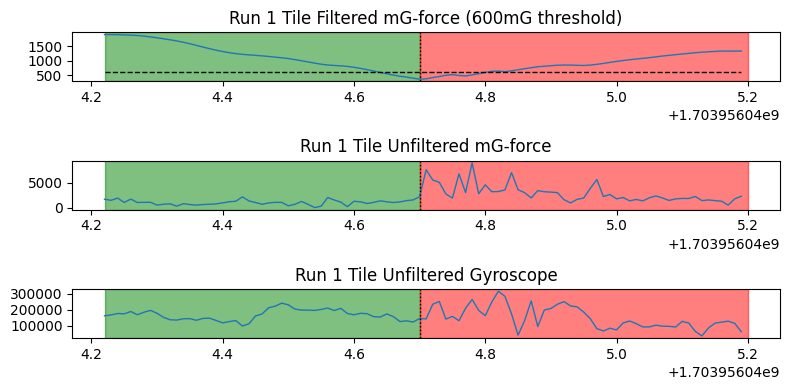

61.53846153846154 %


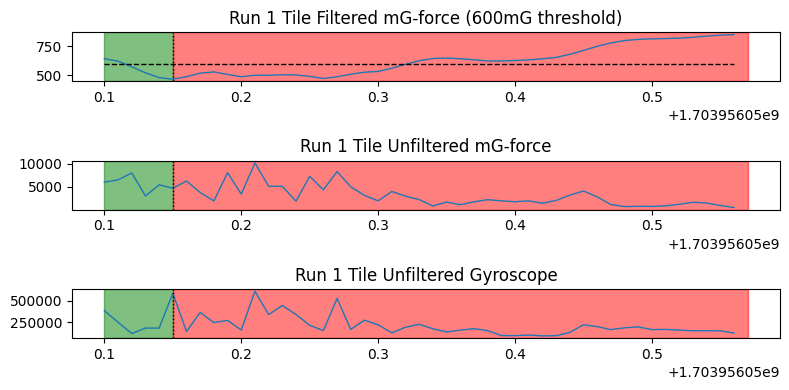

100.0 %


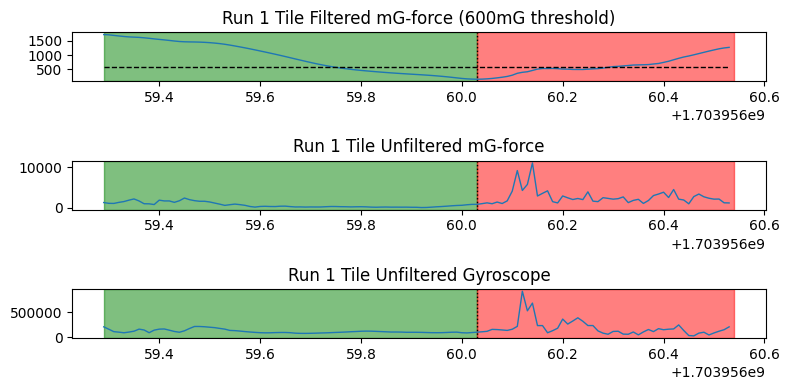

69.23076923076923 %


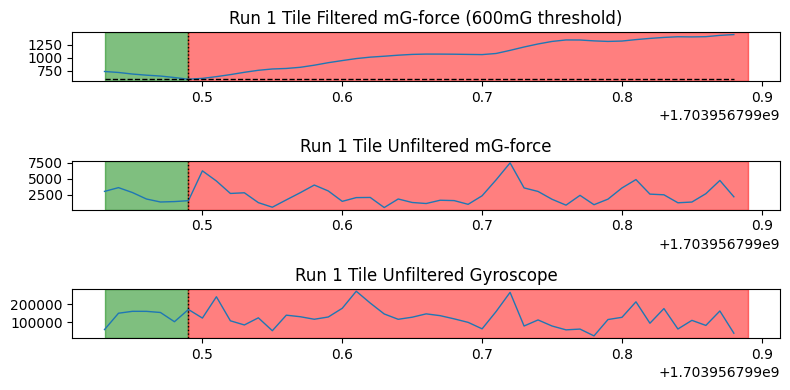

In [256]:
print(p1, '%'); plotJumpAnalysis(run1, identifyJumpKinematics(run1.mG_lpf, run1_jump_ranges[0]))
print(p2, '%'); plotJumpAnalysis(run1, identifyJumpKinematics(run1.mG_lpf, run1_jump_ranges[1]))
print(p3, '%'); plotJumpAnalysis(run1, identifyJumpKinematics(run1.mG_lpf, run1_jump_ranges[2]))
print(p4, '%'); plotJumpAnalysis(run2, identifyJumpKinematics(run2.mG_lpf, run2_jump_ranges[0]))

## Bringing it all Together

- create a jump object to contain all the parsing, range id, testing, and confidence values
- each `Tile`, i.e. track, will contain an array of jumps
- generating the list of jumps can be done directly from a `Tile` object
  - could be passed up


### Aside / todos

- jump timing realignment, to correct for local G-force minima